# Comparative plots with survey results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("bmh")
%matplotlib inline
import geopandas as gpd
import math

Use these colors for the project

https://clauswilke.com/dataviz/color-pitfalls.html

orange #E69F00

sky blue #56B4E9

bluish green #009E73

yellow #F0E442

blue #0072B2

vermilion #D55E00

reddish purple #CC79A7

black #000000


In [2]:
blue = '#0072B2'
bluegreen = '#009E73'
yellow = '#F0E442'
skyblue = '#56B4E9'
orange = '#E69F00'
vermilion = '#D55E00'

## Geospatial data

In [3]:
gdf_nuts3 = gpd.read_file(
    'data/NUTS_RG_01M_2021_3857_LEVL_3.shp.zip',
    crs = "EPSG:4326"
)

In [4]:
# Filter out all countries except Norway
gdf_NOnuts3 = gdf_nuts3[gdf_nuts3.CNTR_CODE.str.contains('NO')]
gdf_NOnuts3.head()

,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,NO0B2,3,NO,Svalbard,Svalbard,3.0,3.0,1,NO0B2,"MULTIPOLYGON (((3683707.656 15700391.322, 3684..."
1,NO0B1,3,NO,Jan Mayen\r\n \r\n,Jan Mayen\r\n \r\n,NaN,NaN,1,NO0B1,"POLYGON ((-886373.017 11457887.685, -885579.47..."
544,NO082,3,NO,Viken,Viken,2.0,2.0,1,NO082,"MULTIPOLYGON (((1317992.603 8364371.423, 13195..."
718,NO0A1,3,NO,Rogaland,Rogaland,2.0,2.0,1,NO0A1,"MULTIPOLYGON (((789955.111 8351533.565, 791546..."
719,NO0A2,3,NO,Vestland,Vestland,3.0,2.0,1,NO0A2,"MULTIPOLYGON (((611306.308 8862650.013, 612360..."


In [5]:
# We manually filter out Svalbard and Jan Mayen as we are not interested in them
gdf_NOnuts3 = gdf_NOnuts3.query('FID != "NO0B1" and FID != "NO0B2"')

In [6]:
# Return to sequential index from 0 to 13
gdf_NOnuts3 = gdf_NOnuts3.reset_index()

In [7]:
# Set the coordinate reference system to EPSG:4326 - same as our twitter data. 
gdf_NOnuts3 = gdf_NOnuts3.to_crs("EPSG:4326")

## Sentiment data from surveys

## Round 16, 2019

In [8]:
columns = ['R16p3','R16km_wind_a','R16km_wind_b']

df_uib_sent = pd.read_spss('data/Norsk_medborgerpanel_runde_16_2019.sav', usecols = columns)

df_uib_sent = df_uib_sent.rename(columns={'Responseid': 'ID','R16p3': 'County','R16km_wind_a': 'Onshore','R16km_wind_b': 'Offshore'}, index={'ONE': 'Row_1'})

In [9]:
df_uib_sent = df_uib_sent.set_index('County')

In [10]:
df_uib_sent.groupby('County').size()

County
Akershus            1680
Aust-agder           242
Buskerud             648
Finmark              142
Hedmark              366
Hordaland           1539
Møre og romsdal      530
Nordland             492
Oppland              354
Oslo                1992
Rogaland            1194
Sogn og fjordane     235
Telemark             353
Troms                392
Trøndelag           1087
Vest-agder           423
Vestfold             608
Østfold              627
dtype: int64

In [11]:
df_onshore = df_uib_sent.groupby(
        ['County',
         'Onshore']
).size(
).drop(
    ['Not asked'],
    level = 1
).rename(
    {'Agree somewhat' : 'Agree',
     'Strongly agree' : 'Agree',
     'Disagree somewhat' : 'Disagree',
     'Strongly disagree':'Disagree'}
).groupby(
    ['County',
    'Onshore']
).sum(
).unstack(
).rename(
    {'Akershus' : 'Viken',
     'Østfold' : 'Viken',
     'Buskerud' : 'Viken',
     'Aust-agder' : 'Agder',
     'Vest-agder' : 'Agder',
     'Finmark' : 'Troms og Finnmark',
     'Troms' : 'Troms og Finnmark',
     'Hedmark' : 'Innlandet',
     'Oppland' : 'Innlandet',
     'Hordaland' : 'Vestland',
     'Sogn og fjordane' : 'Vestland',
     'Møre og romsdal' : 'Møre og Romsdal',
     'Vestfold' : 'Vestfold og Telemark',
     'Telemark' : 'Vestfold og Telemark'
    }
).groupby('County').sum(
)

In [12]:
df_uib_sent

,Onshore,Offshore
County,,
Oppland,Not asked,Not asked
Hordaland,Disagree,Agree
Rogaland,Strongly disagree,Agree somewhat
Akershus,Not asked,Not asked
Buskerud,Not asked,Not asked
...,...,...
Oslo,Not asked,Not asked
Akershus,Not asked,Not asked
Buskerud,Not asked,Not asked


In [13]:
replies = df_uib_sent.drop(columns={'Offshore'}).query('Onshore != "Not asked"').groupby('County').size().rename(
    {'Akershus' : 'Viken',
     'Østfold' : 'Viken',
     'Buskerud' : 'Viken',
     'Aust-agder' : 'Agder',
     'Vest-agder' : 'Agder',
     'Finmark' : 'Troms og Finnmark',
     'Troms' : 'Troms og Finnmark',
     'Hedmark' : 'Innlandet',
     'Oppland' : 'Innlandet',
     'Hordaland' : 'Vestland',
     'Sogn og fjordane' : 'Vestland',
     'Møre og romsdal' : 'Møre og Romsdal',
     'Vestfold' : 'Vestfold og Telemark',
     'Telemark' : 'Vestfold og Telemark'
    }
).groupby('County').sum()

In [14]:
df_onshore_2019 = df_onshore.copy()
df_onshore_2019 = df_onshore_2019.div(replies,axis=0)

## Round 22, 2021

In [15]:
cols_list = ['r22P3','r22km_wind_a','r22km_wind_b']

In [16]:
translator_county = {
    3 : 'Oslo',
    11 : 'Rogaland',
    15 : 'Møre og Romsdal',
    18 : 'Nordland',
    30 : 'Viken',
    34 : 'Innlandet',
    38 : 'Vestfold og Telemark',
    42 : 'Agder',
    46 : 'Vestland',
    50 : 'Trøndelag',
    54 : 'Troms og Finnmark',
}

In [17]:
translator_responses = {
    1 : 'Strongly agree',
    2 : 'Agree',
    3 : 'Somewhat agree',
    4 : 'Neither agree nor disagree',
    5 : 'Somewhat disagree',
    6 : 'Disagree',
    7 : 'Strongly disagree',
    97 : 'Not answered',
    98 : 'Not asked',
}

In [18]:
uib_sent_2021 = pd.read_csv('data/round22.csv', usecols=cols_list).rename(
    columns={
        'r22P3' : 'County',
        'r22km_wind_a' : 'Onshore',
        'r22km_wind_b' : 'Offshore',
    }
)
uib_sent_2021['County'] = uib_sent_2021['County'].replace(translator_county)

uib_sent_2021[['Onshore','Offshore']] = uib_sent_2021[['Onshore','Offshore']].replace(translator_responses)

In [19]:
uib_onshore_2021 = uib_sent_2021.groupby(
        ['County',
         'Onshore']
).size(
).drop(
    ['Not asked'],
    level = 1
).rename(
    {'Somewhat agree' : 'Agree',
     'Strongly agree' : 'Agree',
     'Somewhat disagree' : 'Disagree',
     'Strongly disagree':'Disagree'}
).groupby(
    ['County',
    'Onshore']
).sum(
).unstack(
#).rename(
#    {'Akershus' : 'Viken',
#     'Østfold' : 'Viken',
#     'Buskerud' : 'Viken',
#     'Aust-agder' : 'Agder',
#     'Vest-agder' : 'Agder',
#     'Finmark' : 'Troms og Finnmark',
#     'Troms' : 'Troms og Finnmark',
#     'Hedmark' : 'Innlandet',
#     'Oppland' : 'Innlandet',
#     'Hordaland' : 'Vestland',
#     'Sogn og fjordane' : 'Vestland',
#     'Møre og romsdal' : 'Møre og Romsdal',
#     'Vestfold' : 'Vestfold og Telemark',
#     'Telemark' : 'Vestfold og Telemark'
#    }
#).groupby('County').sum(
)

uib_onshore_2021

Onshore,Agree,Disagree,Neither agree nor disagree,Not answered
County,,,,
Agder,25.0,51.0,10.0,1.0
Innlandet,48.0,42.0,18.0,NaN
Møre og Romsdal,31.0,31.0,7.0,NaN
Nordland,32.0,37.0,7.0,NaN
Oslo,179.0,120.0,25.0,NaN
Rogaland,54.0,111.0,14.0,NaN
Troms og Finnmark,27.0,30.0,9.0,NaN
Trøndelag,46.0,79.0,18.0,NaN
Vestfold og Telemark,71.0,56.0,20.0,1.0


In [20]:
replies_2021 = uib_sent_2021.drop(columns={'Offshore'}).query('Onshore != "Not asked"').groupby('County').size(
).groupby('County').sum()

In [21]:
uib_onshore_2021 = uib_onshore_2021.div(replies_2021,axis=0)

## 2019 and 2021 onshore

In [22]:
df_onshore_2019_2 = df_onshore_2019.assign(Year = 2019)

In [23]:
df_onshore_2021_2 = uib_onshore_2021.assign(Year = 2021)

In [24]:
df_uib_2019_2021 = df_onshore_2019_2.reset_index().append(df_onshore_2021_2.reset_index())

/tmp/ipykernel_40361/2579341913.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_uib_2019_2021 = df_onshore_2019_2.reset_index().append(df_onshore_2021_2.reset_index())


## Sentiment/Twitter data

In [25]:
df_twitter = pd.read_csv("data/fourth_rendition_geolocated_id_posneutral_predict.csv",
                 parse_dates=['created_at']
)

In [26]:
# Transform the twitter data it into a GeoDataFrame with point geometry based on longitude and latitude.
gdf_twitter = gpd.GeoDataFrame(
    df_twitter,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(df_twitter.longitude, df_twitter.latitude)
)

In [27]:
gdf_twitter = gdf_twitter.rename(columns={"loc": "city"})

In [28]:
# Spatial joins https://geopandas.org/docs/user_guide/mergingdata.html#spatial-joins
# Basically, we add an attribute for each city related to the county the coordinate is located inside.
gdf_twitter_with_county = gdf_twitter.sjoin(gdf_NOnuts3, how = "inner", predicate = 'intersects')

In [29]:
gdf_twitter_with_county.loc[gdf_twitter_with_county['created_at'].dt.to_period('Y') == '2019' 
                           ].groupby('NUTS_NAME').sum().label

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


NUTS_NAME
Agder                     80.0
Innlandet                497.0
Møre og Romsdal          166.0
Nordland                 129.0
Oslo                    5868.0
Rogaland                 707.0
Troms og Finnmark        122.0
Trøndelag               1103.0
Vestfold og Telemark     179.0
Vestland                1521.0
Viken                    567.0
Name: label, dtype: float64

In [30]:
df_twitter_2019 = gdf_twitter_with_county.loc[gdf_twitter_with_county['created_at'].dt.to_period('Y') == '2019' 
                           ].groupby('NUTS_NAME').count().drop(
    columns = {
        'Unnamed: 0',
        'id',
        'username',
        'like_count',
        'quote_count',
        'latitude',
        'longitude',
         'index_right',
        'index',
        'LEVL_CODE',
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'geometry',
        'NUTS_ID',
        'CNTR_CODE',
        'NAME_LATN',
        'FID',
        'logits0',
        'logits1',
        'text',
        'city',
        'created_at'
    }
).rename(
    columns={
        'label' : 'total_tweets'
    }
).assign(
    non_negative_tweets = gdf_twitter_with_county.loc[gdf_twitter_with_county['created_at'].dt.to_period('Y') == '2019' ].groupby('NUTS_NAME').sum().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x : x.negative_tweets/x.total_tweets,
    share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


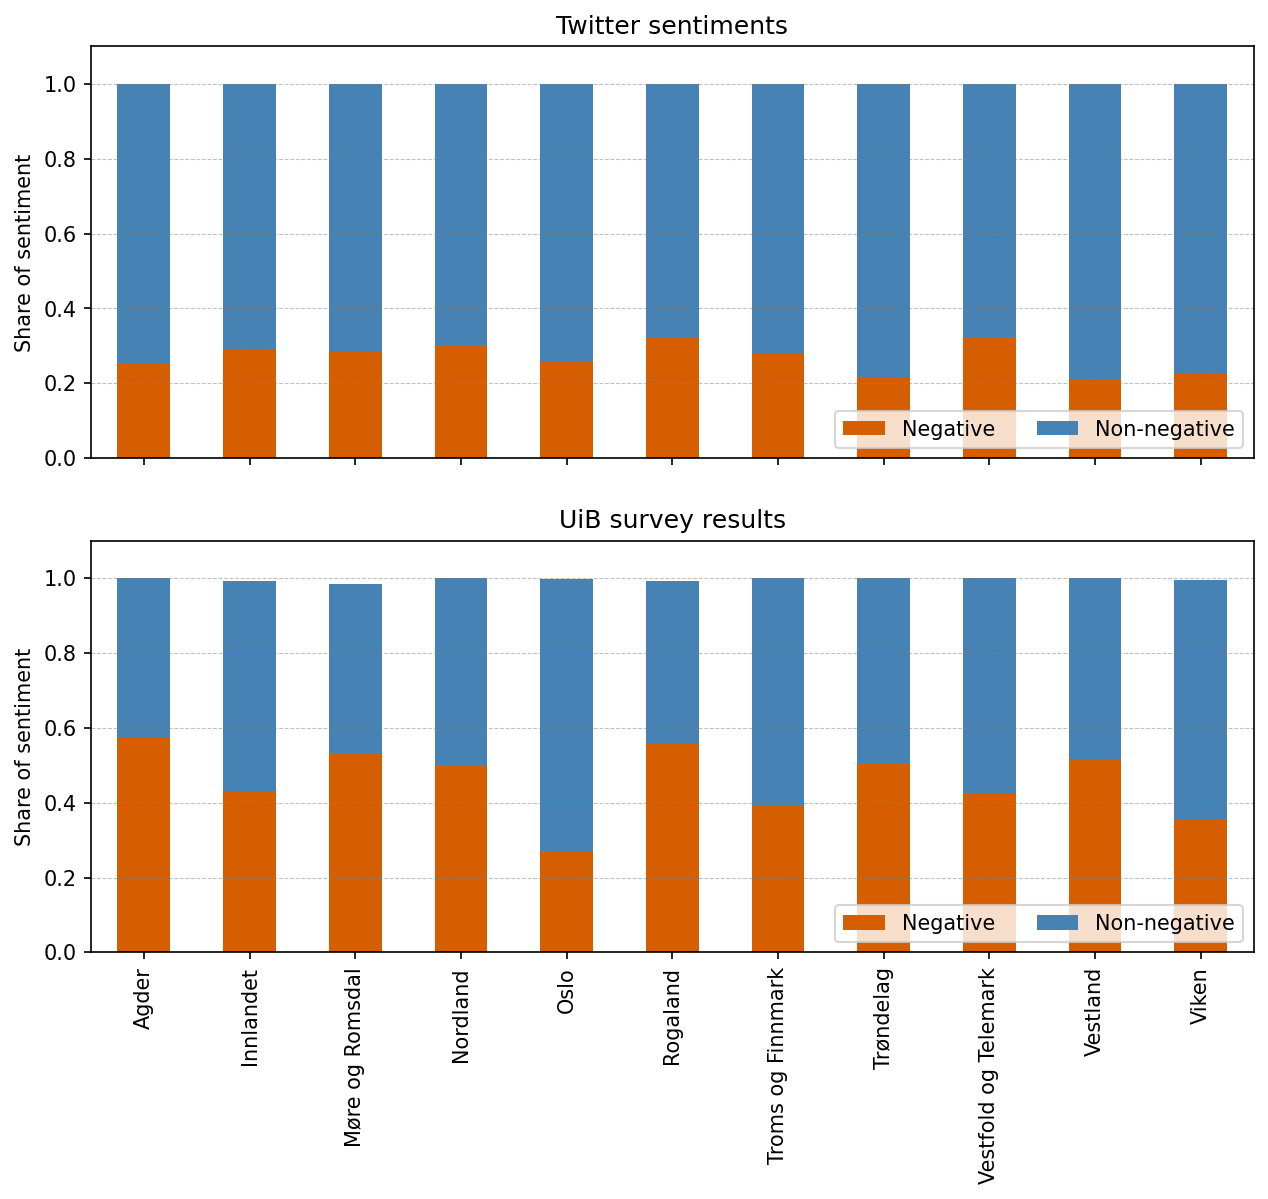

In [31]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(10,8),
    dpi = 150
)
gs = fig.add_gridspec(2,1)

df_twitter_2019.plot.bar(
    ax=fig.add_subplot(gs[0,0]),
    y = ['share_negative','share_non_negative',],
    stacked=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue']
)

plt.legend(['Negative','Non-negative',],loc='lower right', 
          ncol=2)
plt.title('Twitter sentiments')
plt.ylabel('Share of sentiment')
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)

df_onshore.div(
    replies,
    axis = 0
).rename(
    columns = {
        'Neither agree nor disagree' : 'neither',
        'Not answered' : 'not_answered',
    }
).assign(
    Non_negative = lambda x : x.Agree + x.neither,
    Negative = lambda x : x.Disagree
).plot.bar(
    ax=fig.add_subplot(gs[1,0]),
    y = ['Negative','Non_negative'],
    stacked=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue'],
    sharex=True
)

plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
plt.title('UiB survey results')
plt.xlabel("")
plt.ylabel('Share of sentiment')
plt.legend(['Negative','Non-negative'],loc='lower right', 
          ncol=2)

plt.savefig('figures/2019_comparision_uibTwitter.pdf',bbox_inches='tight')

# Comparing with CICERO survey data for 2018-2021

In [32]:
cicero_sent = pd.DataFrame(index = {2018,2019,2020,2021})

In [33]:
df_cicero_data = pd.read_csv('data/cicero_sentiment.csv').rename(
    columns={
        'Stemmer svært dårlig' : 'Disagree_much',
        'Stemmer ganske dårlig' : 'Disagree',
        'Stemmer verken dårlig eller godt' : 'Neither',
        'Stemmer ganske godt' : 'Agree',
        'Stemmer svært godt' : 'Agree_much',
        'Vet ikke' : 'Dont_know'
    }
).set_index('Year')

In [34]:
df_cicero_data

,Disagree_much,Disagree,Neither,Agree,Agree_much,Dont_know,Total
Year,,,,,,,
2018,3.6,6.4,16.7,42.5,21.7,8.0,99.0
2019,11.8,11.6,17.7,30.9,19.9,7.3,99.2
2020,19.0,13.5,18.9,24.6,15.8,7.4,99.1
2021,24.2,15.3,20.3,21.4,10.8,7.0,99.0


In [35]:
cicero_sent = pd.DataFrame(index = {2018,2019,2020,2021})
cicero_sent = cicero_sent.assign(
    Non_negative = df_cicero_data.Agree + df_cicero_data.Agree_much + df_cicero_data.Dont_know + df_cicero_data.Neither,
    Negative =  df_cicero_data.Disagree + df_cicero_data.Disagree_much,
).div(100)

In [36]:
twitter_yearly = df_twitter.copy()
twitter_yearly['created_at'] = df_twitter['created_at'].dt.to_period('Y')

twitter_2018_2021 = twitter_yearly.groupby('created_at').count().drop(
    columns = {
        'Unnamed: 0',
        'id',
        'username',
        'like_count',
        'quote_count',
        'latitude',
        'longitude',
        'logits0',
        'logits1',
        'text',
        'loc',
        'geometry'
    }
).rename(
    columns={
        'label' : 'total_tweets'
    }
).assign(
    non_negative_tweets = twitter_yearly.groupby('created_at').sum().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x : x.negative_tweets/x.total_tweets,
    share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
).loc[['2018','2019','2020','2021']]

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [37]:
twitter_2018_2021

,total_tweets,non_negative_tweets,negative_tweets,share_negative,share_non_negative
created_at,,,,,
2018,4442,3284.0,1158.0,0.260693,0.739307
2019,15783,11678.0,4105.0,0.260090,0.739910
2020,13288,8976.0,4312.0,0.324503,0.675497
2021,9512,7104.0,2408.0,0.253154,0.746846


In [38]:
cicero_sent

,Non_negative,Negative
2018,0.889,0.100
2019,0.758,0.234
2020,0.667,0.325
2021,0.595,0.395


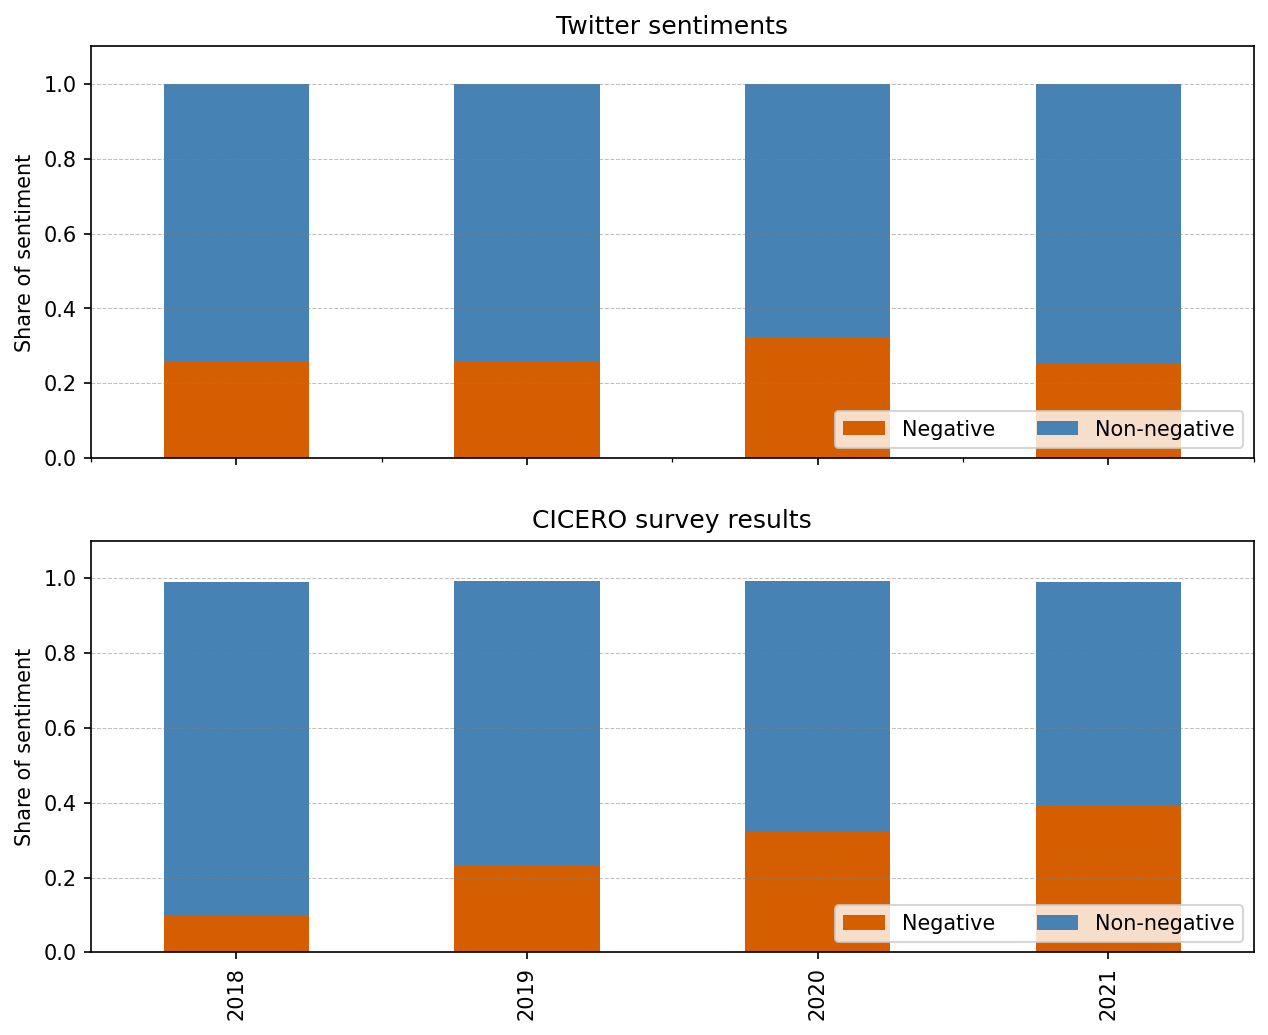

In [39]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(10,8),
    dpi = 150
)
gs = fig.add_gridspec(2,1)

twitter_2018_2021.plot.bar(
    ax=fig.add_subplot(gs[0,0]),
    y = ['share_negative','share_non_negative'],
    stacked=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue']
)

plt.legend(['Negative','Non-negative'],loc='lower right', 
          ncol=2)
plt.title('Twitter sentiments')
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
plt.ylabel('Share of sentiment')

cicero_sent.plot.bar(
    ax=fig.add_subplot(gs[1,0]),
    y = ['Negative','Non_negative',],
    stacked=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue'],
    sharex=True
)

plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
plt.title('CICERO survey results')
plt.xlabel('')
plt.ylabel('Share of sentiment')
plt.legend(['Negative','Non-negative'],loc='lower right', 
          ncol=2)

plt.savefig('figures/2018_2021_comparision_CICEROTwitter.pdf',bbox_inches='tight')

# Comparison with UiB for 2019 and 2021

In [40]:
uib_18_21 = pd.read_csv('data/uib_2019_2021.tsv',sep = '\t').groupby('Year').sum().rename(
    columns = {
        'Verken/eller' : 'neither',
        'Uenig' : 'Negative'
    }
).assign(
    non_negative = lambda x : x.Enig + x.neither,
    total = lambda x : x.Enig + x.neither + x.Negative,
    share_negative = lambda x : x.Negative/x.total,
    share_non_negative = lambda x : x.non_negative/x.total
)

In [41]:
uib_18_21

,Enig,neither,Negative,non_negative,total,share_negative,share_non_negative
Year,,,,,,,
2019,273,54,273,327,600,0.455000,0.545000
2021,235,69,294,304,598,0.491639,0.508361


In [42]:
twitter_2019_2021 = twitter_yearly.groupby('created_at').count().drop(
    columns = {
        'Unnamed: 0',
        'id',
        'username',
        'like_count',
        'quote_count',
        'latitude',
        'longitude',
        'logits0',
        'logits1',
        'text',
        'loc',
        'geometry'
    }
).rename(
    columns={
        'label' : 'total_tweets'
    }
).assign(
    non_negative_tweets = twitter_yearly.groupby('created_at').sum().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x : x.negative_tweets/x.total_tweets,
    share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
)#groupby#.loc[['2019','2021']]

In [43]:
twitter_county_comp = gdf_twitter_with_county[['NUTS_NAME','label','created_at']].copy()
twitter_county_comp = twitter_county_comp.replace(
    {
        'Troms og Finnmark' : 'Northern Norway',
        'Nordland' : 'Northern Norway',
        'Møre og Romsdal' : 'Western Norway',
        'Vestland' : 'Western Norway',
        'Rogaland' : 'Western Norway',
        'Vestfold og Telemark' : 'Eastern Norway',
        'Viken' : 'Eastern Norway',
        'Innlandet' : 'Eastern Norway',
        'Oslo' : 'Eastern Norway',
        'Agder' : 'Southern Norway',
        'Trøndelag' : 'Middle Norway'
    }
)
twitter_county_comp

,NUTS_NAME,label,created_at
0,Western Norway,1.0,2008-12-16 14:43:57+00:00
5,Western Norway,1.0,2008-11-05 14:23:09+00:00
11,Western Norway,1.0,2008-08-05 08:56:27+00:00
15,Western Norway,1.0,2008-05-22 11:36:20+00:00
174,Western Norway,1.0,2009-09-06 15:39:43+00:00
...,...,...,...
68717,Eastern Norway,0.0,2022-10-18 10:20:19+00:00
68720,Eastern Norway,1.0,2022-10-18 09:50:34+00:00
68744,Eastern Norway,1.0,2022-10-17 22:18:29+00:00
68752,Eastern Norway,1.0,2022-10-17 19:28:49+00:00


In [44]:
twitter_county_comp = gdf_twitter_with_county[['NUTS_NAME','label','created_at']].copy()

twitter_county_comp['created_at'] = twitter_county_comp['created_at'].dt.to_period('Y')
twitter_county_comp_2019_2021 = twitter_county_comp.groupby(['created_at','NUTS_NAME']).count().loc[['2019','2021']].rename(
    columns={
        'label' : 'total_tweets'
    }
).assign(
    non_negative_tweets = twitter_county_comp.groupby(['created_at','NUTS_NAME']).sum().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x : x.negative_tweets/x.total_tweets,
    share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
)

#twitter_county_comp_2019_2021

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


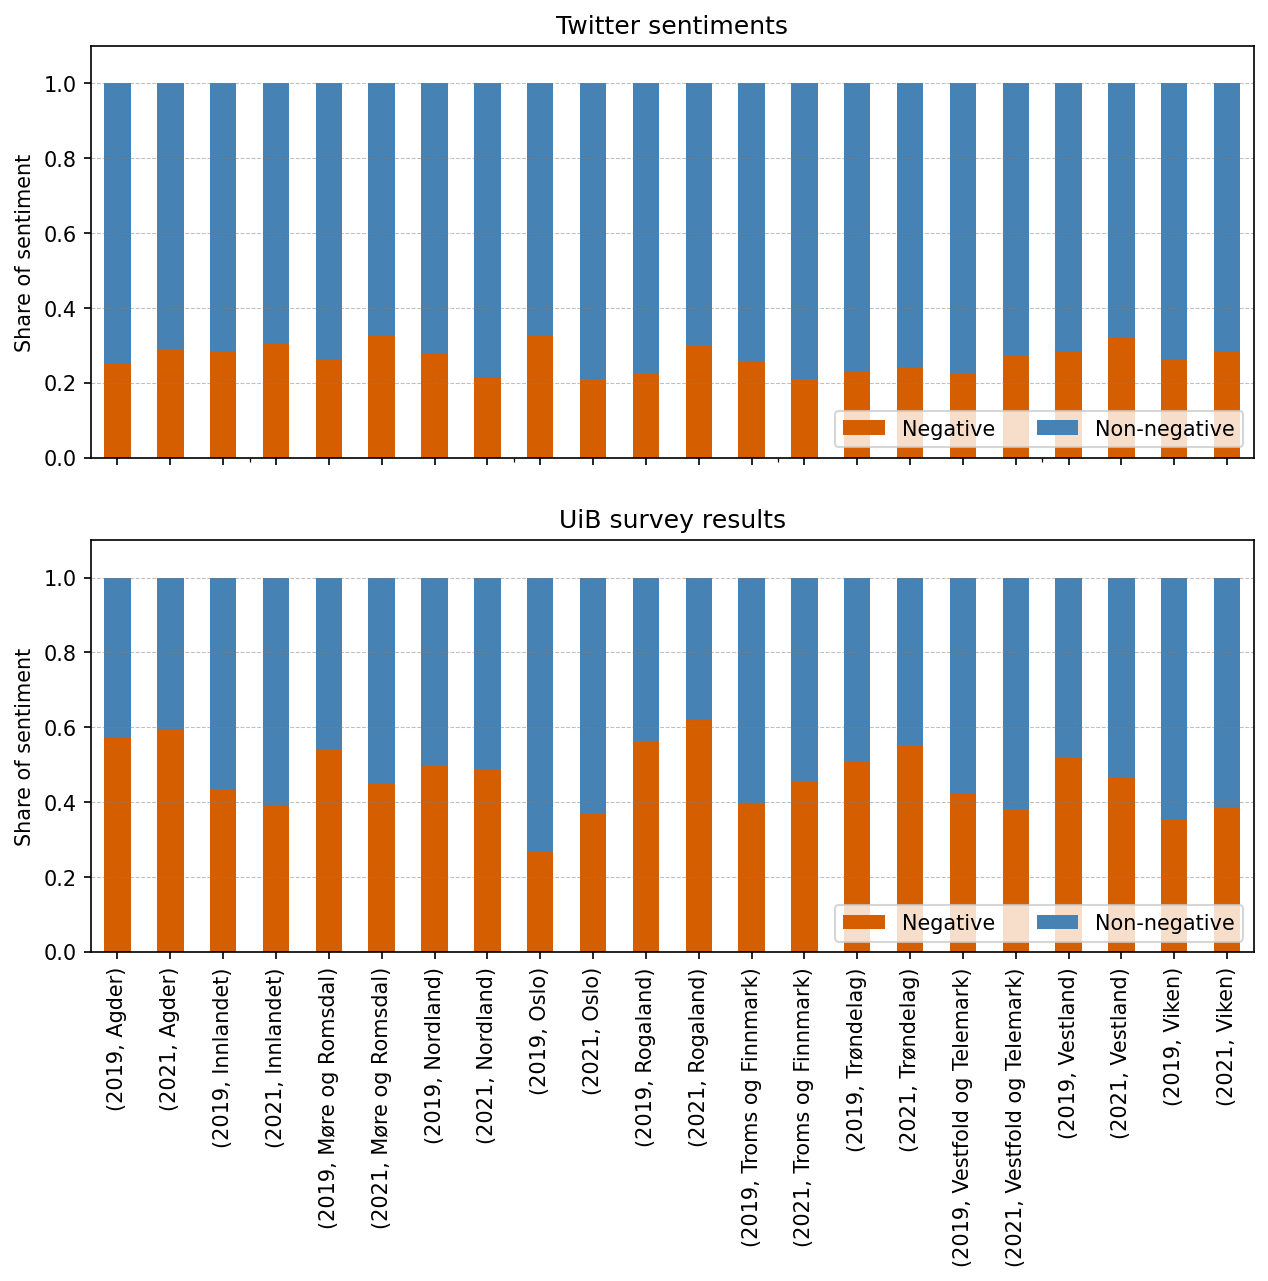

In [45]:
fig = plt.figure(
    constrained_layout=False,
    figsize=(10,8),
    dpi = 150
)
gs = fig.add_gridspec(2,1)

twitter_county_comp_2019_2021.plot.bar(
    ax=fig.add_subplot(gs[0,0]),
    y = ['share_negative','share_non_negative'],
    stacked=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue',]
)

plt.legend(['Negative','Non-negative'],loc='lower right', 
          ncol=2)
plt.title('Twitter sentiments')
plt.ylabel('Share of sentiment')
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)

df_uib_2019_2021.groupby(['Year','County']).sum().sort_index(level=1).rename(
    columns = {
        'Neither agree nor disagree' : 'neither',
        'Not answered' : 'not_answered'
    }
).assign(
    non_negative = lambda x : x.Agree + x.neither,
    total = lambda x : x.Agree + x.neither + x.Disagree,
    share_negative = lambda x : x.Disagree/x.total,
    share_non_negative = lambda x : x.non_negative/x.total
).plot.bar(
    ax=fig.add_subplot(gs[1,0]),
    stacked=True,
    y = ['share_negative','share_non_negative'],
    sharex=True,
    ylim=[0,1.1],
    color = ['#D55E00','steelblue']
)

plt.legend(['Negative','Non-negative'],loc='lower right', 
          ncol=2)
plt.title('UiB survey results')
plt.ylabel('Share of sentiment')
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
plt.xlabel("")

plt.savefig('figures/2019_2021_comparision_uibTwitter.pdf',bbox_inches='tight')